## Title

In [1]:
import pandas as pd
import sqlite3
from pathlib import Path

In [2]:
# we define the paths we will use
csv_path = Path("../Data/CleanedData.csv")
db_path  = Path("../Data/football.db")

In [3]:
# ===============================================================
# 1) Reset DB and load CSV
# ===============================================================

def reset_database(path: Path):
    if path.exists():
        path.unlink()

reset_database(db_path)

df = pd.read_csv(csv_path).copy()

# Add match_id (required by ERM)
df["match_id"] = range(1, len(df) + 1)

# Clean date + time fields
df["match_date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df["time_hour"]  = df["Time"].astype(int)
df["month"]      = df["Month"].astype(int)
df["day_of_month"] = df["Day"].astype(int)


# ===============================================================
# 2) Build STADIUM dimension
# ===============================================================

stadium_dim = (
    df[["Stadium", "Max Capacity", "City", "Province", "Full Roof"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

stadium_dim.insert(0, "stadium_id", stadium_dim.index + 1)

df = df.merge(
    stadium_dim,
    on=["Stadium", "Max Capacity", "City", "Province", "Full Roof"],
    how="left"
)

stadium_db = stadium_dim.rename(columns={
    "Stadium": "stadium_name",
    "Max Capacity": "max_capacity",
    "City": "city",
    "Province": "province",
    "Full Roof": "full_roof",
})


# ===============================================================
# 3) Build TEAM dimension
# ===============================================================

team_names = sorted(set(df["Home Team"]) | set(df["Away Team"]) | {"Unknown"})

team_db = pd.DataFrame({
    "team_id": range(1, len(team_names) + 1),
    "team_name": team_names
})

team_name_to_id = dict(zip(team_db.team_name, team_db.team_id))

df["home_team_id"] = df["Home Team"].map(team_name_to_id)
df["away_team_id"] = df["Away Team"].map(team_name_to_id)


# ===============================================================
# 4) Build ECONOMIC CONTEXT dimension
# ===============================================================

econ_db = (
    df[[
        "Year", "quarter",
        "GDP_Real_lagQ",
        "CPI_QoQ_Growth_%_lagQ",
        "Employment_Rate_%_lagQ",
    ]]
    .drop_duplicates()
    .rename(columns={
        "Year": "year",
        "quarter": "quarter",
        "GDP_Real_lagQ": "gdp_real_lagq",
        "CPI_QoQ_Growth_%_lagQ": "cpi_qoq_growth_pct_lagq",
        "Employment_Rate_%_lagQ": "employment_rate_pct_lagq",
    })
)


# ===============================================================
# 5) Build MATCH table (follows your ERM exactly)
# ===============================================================

match_db = pd.DataFrame({
    "match_id": df["match_id"],
    "competition": df["Competition"],
    "match_date": df["match_date"].dt.strftime("%Y-%m-%d"),
    "time_hour": df["time_hour"],
    "season": df["Season"],
    "year": df["Year"],
    "quarter": df["quarter"],
    "month": df["month"],
    "day_of_month": df["day_of_month"],
    "stadium_id": df["stadium_id"],
    "match_type": df["Match Type"],
    "attendance": df["Attendance"],
    "percentage_attendance": df["PercentageAttendance"],
    "weather_type": df["Weather"],
    "weather_quality": df["Weather GoodBad"],
    "temperature_c": df["Temperature (°C)"],
    "derby_flag": df["Derby"],
    "matchday_label": df["Matchday"].astype(str),
    "weekday": df["Weekday"],
    "game_day_type": df["Game day"],
    "time_slot": df["Time slot"],
})

match_db = match_db.drop_duplicates(subset=["match_id"])


# ===============================================================
# 6) Build MATCHPARTICIPATION table
# ===============================================================

home_mp = pd.DataFrame({
    "match_id": df["match_id"],
    "team_id": df["home_team_id"],
    "is_home": 1,
    "ranking_at_match": df["Ranking Home Team"],
    "goals_scored": df["Home Team Goals Scored"],
    "outcome": df["Home Team Outcome"],
    "goals_scored_last5": df["Goals Scored in Last 5 Games"],
    "goals_conceded_last5": df["Goals Conceded in Last 5 Games"],
    "wins_last5": df["Number of Wins in Last 5 Games"],
    "team_category": df["Home team Category"],
    "opponent_category": df["Opposing team Category"],
})

away_mp = pd.DataFrame({
    "match_id": df["match_id"],
    "team_id": df["away_team_id"],
    "is_home": 0,
    "ranking_at_match": df["Ranking Away Team"],
    "goals_scored": df["Away Team Goals Scored"],
    "outcome": df["Away Team Outcome"],
    "goals_scored_last5": None,
    "goals_conceded_last5": None,
    "wins_last5": None,
    "team_category": df["Opposing team Category"],
    "opponent_category": df["Home team Category"],
})

mp_db = pd.concat([home_mp, away_mp], ignore_index=True)


# ===============================================================
# 7) Build SQLite schema + Insert everything
# ===============================================================

conn = sqlite3.connect(db_path)
cur  = conn.cursor()

schema_sql = """
PRAGMA foreign_keys = ON;

CREATE TABLE IF NOT EXISTS Team (
    team_id     INTEGER PRIMARY KEY,
    team_name   TEXT NOT NULL UNIQUE
);

CREATE TABLE IF NOT EXISTS Stadium (
    stadium_id    INTEGER PRIMARY KEY,
    stadium_name  TEXT NOT NULL UNIQUE,
    city          TEXT NOT NULL,
    province      TEXT NOT NULL,
    max_capacity  INTEGER NOT NULL,
    full_roof     INTEGER NOT NULL
);

CREATE TABLE IF NOT EXISTS EconomicContext (
    year                         INTEGER NOT NULL,
    quarter                      INTEGER NOT NULL,
    gdp_real_lagq                REAL NOT NULL,
    cpi_qoq_growth_pct_lagq      REAL NOT NULL,
    employment_rate_pct_lagq     REAL NOT NULL,
    PRIMARY KEY (year, quarter)
);

CREATE TABLE IF NOT EXISTS Match (
    match_id             INTEGER PRIMARY KEY,
    competition          TEXT NOT NULL,
    match_date           TEXT NOT NULL,
    time_hour            INTEGER NOT NULL,
    season               TEXT NOT NULL,
    year                 INTEGER NOT NULL,
    quarter              INTEGER NOT NULL,
    month                INTEGER NOT NULL,
    day_of_month         INTEGER NOT NULL,
    stadium_id           INTEGER NOT NULL,
    match_type           TEXT NOT NULL,
    attendance           INTEGER NOT NULL,
    percentage_attendance REAL,
    weather_type         TEXT,
    weather_quality      TEXT,
    temperature_c        REAL,
    derby_flag           INTEGER,
    matchday_label       TEXT,
    weekday              TEXT,
    game_day_type        TEXT,
    time_slot            TEXT,
    FOREIGN KEY (stadium_id) REFERENCES Stadium(stadium_id),
    FOREIGN KEY (year, quarter) REFERENCES EconomicContext(year, quarter)
);

CREATE TABLE IF NOT EXISTS MatchParticipation (
    match_id             INTEGER NOT NULL,
    team_id              INTEGER NOT NULL,
    is_home              INTEGER NOT NULL,
    ranking_at_match     INTEGER,
    goals_scored         INTEGER,
    outcome              TEXT,
    goals_scored_last5   REAL,
    goals_conceded_last5 REAL,
    wins_last5           REAL,
    team_category        TEXT,
    opponent_category    TEXT,
    PRIMARY KEY (match_id, team_id, is_home),
    FOREIGN KEY (match_id) REFERENCES Match(match_id),
    FOREIGN KEY (team_id) REFERENCES Team(team_id)
);
"""

cur.executescript(schema_sql)
conn.commit()

team_db.to_sql("Team", conn, if_exists="append", index=False)
stadium_db.to_sql("Stadium", conn, if_exists="append", index=False)
econ_db.to_sql("EconomicContext", conn, if_exists="append", index=False)
match_db.to_sql("Match", conn, if_exists="append", index=False)
mp_db.to_sql("MatchParticipation", conn, if_exists="append", index=False)

conn.commit()

print("Done. SQLite DB written to:", db_path)
conn.close()


Done. SQLite DB written to: ../Data/football.db


/var/folders/5c/wqf6h9_n6sbf0vf58y7rdgj40000gn/T/ipykernel_64694/1550317775.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_db = pd.concat([home_mp, away_mp], ignore_index=True)


## Our ERD:
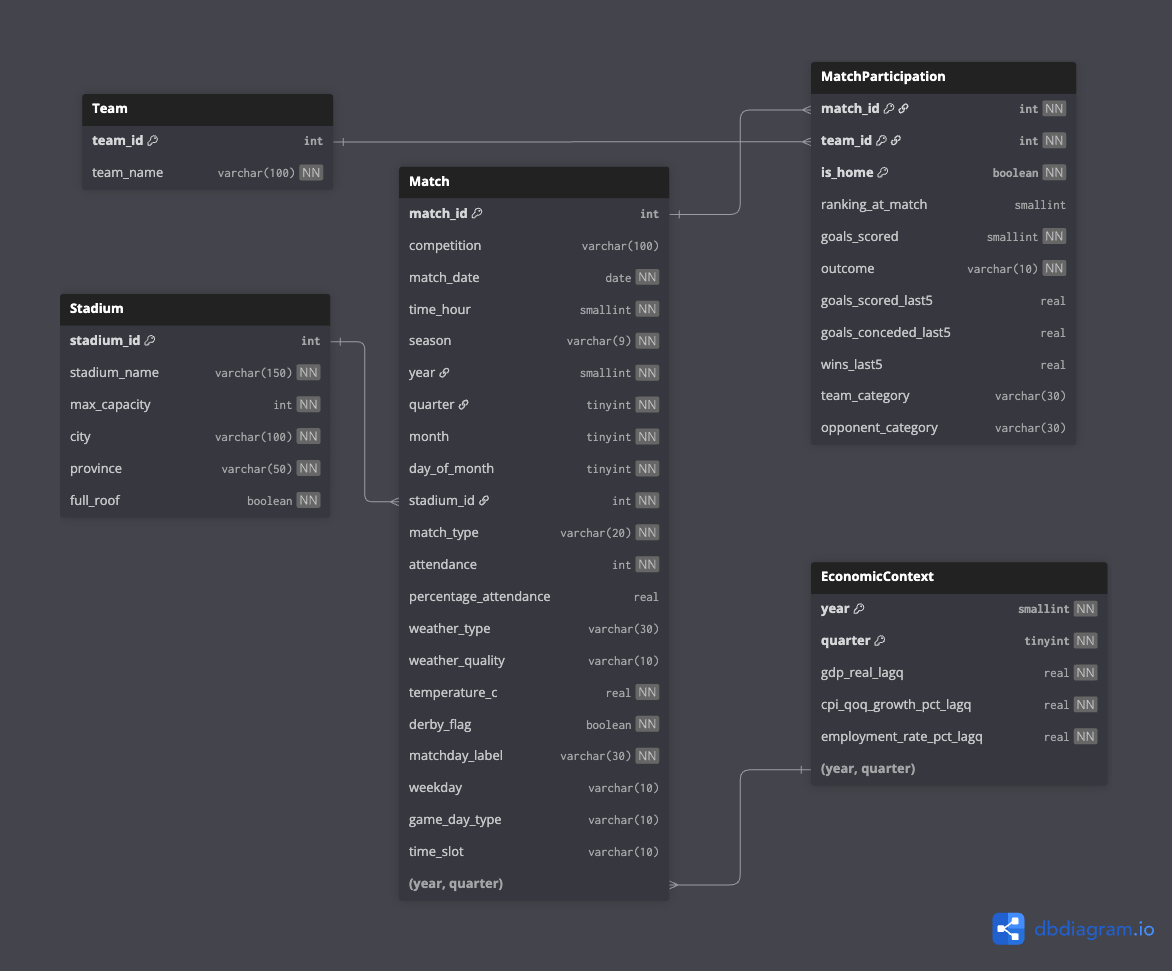